In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_url = "http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/train.csv"
train_df = pd.read_csv(train_url) #training set
test_url = "http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/test.csv"
test_df = pd.read_csv(test_url) #test set

In [3]:
train_df.isna().sum()
# So Age, Cabin and Embarked have missing values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [5]:
train_df.info()
test_df.info()
# So we will have to impute the missing values
# Seem like Cabin missing TOO MUCH values, so we will drop it later

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [6]:
# Fill values with median !!FROM TRAINING DATA!!
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].median())
test_df["Age"] = test_df["Age"].fillna(train_df["Age"].median())

# T8: Median age of training data is
train_df["Age"].median()

28.0

In [7]:
# Fill values with most common value !!FROM TRAIN_dfING DATA!!
train_df["Embarked"] = train_df["Embarked"].fillna(train_df["Embarked"].value_counts().idxmax())
test_df["Embarked"] = test_df["Embarked"].fillna(train_df["Embarked"].value_counts().idxmax())

# T9: Most common port of embarked is
train_df["Embarked"].value_counts().idxmax()

'S'

In [8]:
# Fare and PClass seems to be correlated, so we will use PClass to impute Fare
test_df["Fare"] = test_df["Fare"].fillna(train_df.groupby("Pclass")["Fare"].transform("median"))

In [9]:
embarked_categories = dict([(k,i) for i,k in enumerate(train_df["Embarked"].astype('category').cat.categories.tolist())])
train_df["EmbarkedClass"] = train_df["Embarked"].map(embarked_categories)
test_df["EmbarkedClass"] = test_df["Embarked"].map(embarked_categories)


In [10]:
sex_categories = dict([(k,i) for i,k in enumerate(train_df["Sex"].astype('category').cat.categories.tolist())])
train_df["SexClass"] = train_df["Sex"].map(sex_categories)
test_df["SexClass"] = test_df["Sex"].map(sex_categories)


In [11]:
train_df.isna().sum(),test_df.isna().sum()

# Data is quite cleaned!!

(PassengerId        0
 Survived           0
 Pclass             0
 Name               0
 Sex                0
 Age                0
 SibSp              0
 Parch              0
 Ticket             0
 Fare               0
 Cabin            687
 Embarked           0
 EmbarkedClass      0
 SexClass           0
 dtype: int64,
 PassengerId        0
 Pclass             0
 Name               0
 Sex                0
 Age                0
 SibSp              0
 Parch              0
 Ticket             0
 Fare               0
 Cabin            327
 Embarked           0
 EmbarkedClass      0
 SexClass           0
 dtype: int64)

In [12]:
train_data = np.array(train_df[["Pclass","SexClass","Age","EmbarkedClass"]].values,dtype=np.float32).reshape(-1,4)
train_label = np.array(train_df["Survived"].values,dtype=np.int8).reshape(-1,1)
train_data

array([[ 3.,  1., 22.,  2.],
       [ 1.,  0., 38.,  0.],
       [ 3.,  0., 26.,  2.],
       ...,
       [ 3.,  0., 28.,  2.],
       [ 1.,  1., 26.,  0.],
       [ 3.,  1., 32.,  1.]], dtype=float32)

In [13]:
test_data = np.array(test_df[["Pclass","SexClass","Age","EmbarkedClass"]].values,dtype=np.float32)
test_data

array([[ 3. ,  1. , 34.5,  1. ],
       [ 3. ,  0. , 47. ,  2. ],
       [ 2. ,  1. , 62. ,  1. ],
       ...,
       [ 3. ,  1. , 38.5,  2. ],
       [ 3. ,  1. , 28. ,  2. ],
       [ 3. ,  1. , 28. ,  0. ]], dtype=float32)

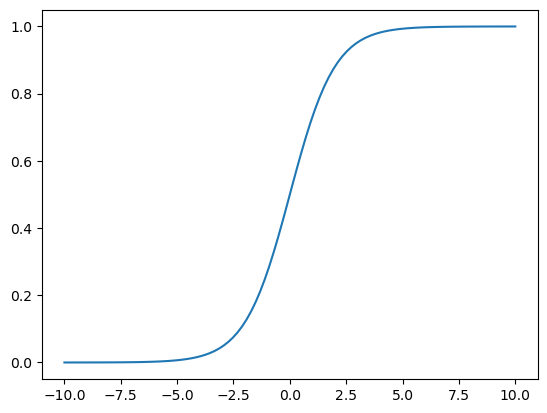

In [14]:
def sigmoid(z): return 1/(1+np.exp(-z))

x = np.linspace(-10,10,100)
z = sigmoid(x)
plt.plot(x,z)

In [106]:
class LogisticRegression:
  def  __init__(self,train_x,train_y,test_x,learning_rate=1e-3) -> None:
    self.train_x = train_x
    self.train_y = train_y
    self.pred = np.zeros_like(train_y)
    self.pred_class = np.zeros_like(train_y)
    self.test_x = test_x
    self.cost,self.grad = self.cost_function()
    self.learning_rate = learning_rate
    self.W = self.__random_init_param()
    self.test_accuracies = []

  def __random_init_param(self):
    #size of X is [m, n] where m=sample, n=features
    self.train_x = self.__add_bias(self.train_x)
    W = np.random.randn(len(self.train_x[0]), 1) # +1 for Bias term
    return W
  
  def __sigmoid(self,z): return 1/(1+np.exp(-z))

  def __add_bias(self,X):
    Bias = np.ones((len(X), 1))
    res = np.concatenate((Bias, X), axis=1)
    return res
  
  def cost_function(self):
    if type(self.pred) == "None" : return None
    m = len(self.train_y)
    loss = np.dot(-self.train_y.T, np.log(self.__sigmoid(self.pred)+1e-10))-np.dot((1-self.train_y).T, np.log((1-self.__sigmoid(self.pred)+1e-10)))
    cost = (1/m) * loss 
    grad = (1/m) * (np.dot(self.train_x.T, (self.__sigmoid(self.pred)-self.train_y)))
    return cost.astype('float64'), grad.astype('float64')

  def predict(self, X=None,sigmoid=True):
    if X is None : X = self.train_x
    h = np.dot(X, self.W)
    return self.__sigmoid(h) if sigmoid else h
  
  def train_accuracy(self):
    return np.squeeze(np.squeeze((sum(self.train_y == self.pred_class)/len(self.train_x))*100))
  

  def step(self):
    #update parameters
    self.W = self.W - self.learning_rate * self.grad
    self.grad = 0
  
  def train(self,epoch=100,interuption_step=10,logging_step=None):
    if logging_step is None : logging_step = epoch**0.5
    loss_step = 0
    best_W = self.W
    for i in range(1,epoch+1):
      self.pred = self.predict(None,False)
      self.pred_class = np.where(self.__sigmoid(self.pred) >= 0.5, 1, 0)
      cost, grad = self.cost_function()
      self.grad = grad
      self.step()
      if i%logging_step == 0: print(f"Epoch {i}/{epoch} : Train accuracy {self.train_accuracy()}%")
      if cost.item() < self.cost.item() : 
        loss_step = 0
        best_W = self.W
      else :
        loss_step += 1
        if loss_step == interuption_step :
          print(f"Loss is increasing, stop training at epoch {i}")
          self.W = best_W
          break
      self.cost = cost
  
  def test(self):
    self.test_pred = self.predict(self.__add_bias(self.test_x))
    return self.test_pred


In [107]:
r = LogisticRegression(train_data,train_label,test_data,0.003)

In [108]:
r.train(1000000)

Epoch 1000/1000000 : Train accuracy 70.03367003367003%
Epoch 2000/1000000 : Train accuracy 75.98204264870931%
Epoch 3000/1000000 : Train accuracy 76.31874298540964%
Epoch 4000/1000000 : Train accuracy 76.87991021324355%
Epoch 5000/1000000 : Train accuracy 77.77777777777779%
Epoch 6000/1000000 : Train accuracy 78.45117845117845%
Epoch 7000/1000000 : Train accuracy 78.45117845117845%
Epoch 8000/1000000 : Train accuracy 78.33894500561168%
Epoch 9000/1000000 : Train accuracy 78.67564534231201%
Epoch 10000/1000000 : Train accuracy 78.00224466891133%
Epoch 11000/1000000 : Train accuracy 78.33894500561168%
Epoch 12000/1000000 : Train accuracy 78.33894500561168%
Epoch 13000/1000000 : Train accuracy 78.67564534231201%
Epoch 14000/1000000 : Train accuracy 78.67564534231201%
Epoch 15000/1000000 : Train accuracy 78.67564534231201%
Epoch 16000/1000000 : Train accuracy 78.67564534231201%
Epoch 17000/1000000 : Train accuracy 78.67564534231201%
Epoch 18000/1000000 : Train accuracy 78.67564534231201%
E

In [110]:
r.cost_function()

(array([[0.44872295]]),
 array([[-6.82110647e-08],
        [ 1.37139531e-08],
        [ 1.23483610e-08],
        [ 7.19484802e-10],
        [ 4.84651579e-09]]))

In [111]:
len(r.pred_class[r.pred_class > 0.5]),len(r.train_y[r.train_y == 1])

(331, 342)

In [112]:
r.train_accuracy()

array(79.01234568)

In [113]:
res = r.test()

In [114]:
pred_class = np.where(res>=0.5,1,0)
pred_class

array([[0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
    

In [115]:
len(res[res > 0.5]),len(res[res < 0.5])

(162, 256)

In [116]:
test_df["Survived"] = pred_class
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,EmbarkedClass,SexClass,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,1,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,2,0,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,2,1,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,28.0,0,0,A.5. 3236,8.0500,NaN,S,2,1,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0,0,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,2,1,0
416,1308,3,"Ware, Mr. Frederick",male,28.0,0,0,359309,8.0500,NaN,S,2,1,0


In [117]:
# T10: My submission is
test_df[["PassengerId","Survived"]].to_csv("submission.csv",index=False)



# T11: My submission score is 0.76076
![Alt text](image.png)

In [122]:
from sklearn.preprocessing import PolynomialFeatures
poly=PolynomialFeatures(degree=2,include_bias=False)
poly_features_train=poly.fit_transform(train_data)
poly_features_test=poly.fit_transform(test_data)

In [134]:
model2 = LogisticRegression(poly_features_train,train_label,poly_features_test,0.003)
model2.train(1000000)
res2 = model2.test()

/tmp/ipykernel_221378/758278441.py:19: RuntimeWarning: overflow encountered in exp
  def __sigmoid(self,z): return 1/(1+np.exp(-z))


Epoch 1000/1000000 : Train accuracy 71.8294051627385%
Epoch 2000/1000000 : Train accuracy 62.177328843995504%
Epoch 3000/1000000 : Train accuracy 77.32884399551067%
Epoch 4000/1000000 : Train accuracy 42.98540965207632%
Epoch 5000/1000000 : Train accuracy 79.01234567901234%
Epoch 6000/1000000 : Train accuracy 71.60493827160494%
Epoch 7000/1000000 : Train accuracy 79.34904601571269%
Epoch 8000/1000000 : Train accuracy 79.2368125701459%
Epoch 9000/1000000 : Train accuracy 76.99214365881033%
Epoch 10000/1000000 : Train accuracy 74.5230078563412%
Epoch 11000/1000000 : Train accuracy 72.16610549943884%
Epoch 12000/1000000 : Train accuracy 72.50280583613917%
Epoch 13000/1000000 : Train accuracy 64.53423120089786%
Epoch 14000/1000000 : Train accuracy 64.42199775533109%
Epoch 15000/1000000 : Train accuracy 58.13692480359147%
Epoch 16000/1000000 : Train accuracy 78.56341189674522%
Epoch 17000/1000000 : Train accuracy 75.42087542087542%
Epoch 18000/1000000 : Train accuracy 63.07519640852974%
Epo

In [135]:
model2.cost_function()

/tmp/ipykernel_221378/758278441.py:19: RuntimeWarning: overflow encountered in exp
  def __sigmoid(self,z): return 1/(1+np.exp(-z))


(array([[4.52924676]]),
 array([[ 0.04398714],
        [ 0.1066733 ],
        [-0.04601717],
        [ 0.64027905],
        [ 0.05995578],
        [ 0.29803205],
        [-0.14987163],
        [ 2.11926597],
        [ 0.17642912],
        [-0.04601717],
        [-1.69215013],
        [-0.08975483],
        [-0.08944415],
        [ 0.73012458],
        [ 0.11209006]]))

In [136]:
model2.pred_class.sum(),len(model2.train_y[model2.train_y == 1])

(381, 342)

In [137]:
res2_class = np.where(res2>=0.5,1,0)
res2_class

array([[0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
    

In [143]:
test_data

array([[ 3. ,  1. , 34.5,  1. ],
       [ 3. ,  0. , 47. ,  2. ],
       [ 2. ,  1. , 62. ,  1. ],
       ...,
       [ 3. ,  1. , 38.5,  2. ],
       [ 3. ,  1. , 28. ,  2. ],
       [ 3. ,  1. , 28. ,  0. ]], dtype=float32)

In [144]:
test_df["Survived"] = res2_class
test_df[['PassengerId','Survived']].to_csv('submission2.csv',index=False)

# T12: My submission has acccuracy of model2 is worse than fisrt try
![Alt text](image-1.png)

In [149]:
model3 = LogisticRegression(np.array(train_df[["SexClass","Age"]].values,dtype=np.float32).reshape(-1,2),train_label,np.array(test_df[["SexClass","Age"]].values,dtype=np.float32).reshape(-1,2),0.003)
model3.train(1000000)
model3.cost_function()

Epoch 1000/1000000 : Train accuracy 61.27946127946128%
Epoch 2000/1000000 : Train accuracy 69.36026936026936%
Epoch 3000/1000000 : Train accuracy 75.42087542087542%
Epoch 4000/1000000 : Train accuracy 76.87991021324355%
Epoch 5000/1000000 : Train accuracy 76.43097643097643%
Epoch 6000/1000000 : Train accuracy 78.00224466891133%
Epoch 7000/1000000 : Train accuracy 78.67564534231201%
Epoch 8000/1000000 : Train accuracy 78.67564534231201%
Epoch 9000/1000000 : Train accuracy 78.67564534231201%
Epoch 10000/1000000 : Train accuracy 78.67564534231201%
Epoch 11000/1000000 : Train accuracy 78.67564534231201%
Epoch 12000/1000000 : Train accuracy 78.67564534231201%
Epoch 13000/1000000 : Train accuracy 78.67564534231201%
Epoch 14000/1000000 : Train accuracy 78.67564534231201%
Epoch 15000/1000000 : Train accuracy 78.67564534231201%
Epoch 16000/1000000 : Train accuracy 78.67564534231201%
Epoch 17000/1000000 : Train accuracy 78.67564534231201%
Epoch 18000/1000000 : Train accuracy 78.67564534231201%
E

(array([[0.51473029]]),
 array([[-6.83343679e-08],
        [ 3.55052215e-08],
        [ 1.34485249e-09]]))

In [150]:
res3 = model3.test()
res3_class = np.where(res3>=0.5,1,0)
test_df["Survived"] = res3_class
test_df[['PassengerId','Survived']].to_csv('submission3.csv',index=False)

# T13: Seems a bit better?
![Alt text](image-2.png)